# Create Nightly Epoch Lightcurves

Contact: Melissa Graham

Create nightly-epoch lightcurves for "good" candidates for all DECam DDF observations
(not just those obtained in 2021, which was the focus of Paper I).
Measure lightcurve summary parameters: time span, amplitude, minimum magnitude, and number of epochs.

Note that the "too-small magnitude errors" issue has been resolved and any remaining mentions
of the issue in this notebook are residual.

The first steps to identifying "good" candidates are:
 1. Identify and reject "bad" objects (dections): objects with R/B scores < 0.1.
 2. Reject all candidates (associations of objects) with < 10 objects (detections).
 3. Reject all candidates with mean R/B scores < 0.4.

This is slightly different from the 2021 process, which 
and did not reject objects with R/B < 0.1.

Then, for a given candidate, the photometry for all objects for a given filter on a given night 
(including those with R/B < 0.4) are combined to make nightly-epoch lightcurves.

The "Lonely Epoch" flag is set to `True` for any single nightly-epoch photometry point
for which the mean R/B score of its objects is < 0.4 **and** there is no epoch with a
mean R/B score > 0.4 within 14 days.
These "lonely epochs" are more likely to be spurious coincidences with artifacts and 
we don't want to include these epochs in our lightcurve summary paramters.

Then the lightcurve summary parameters are calculated, excluding "lonely epochs".

Finally, the lightcurves and lightcurve summary parameters for all "good" candidates
are written out to two files:
 * all_nightly_epochs_files/candidate_lightcurves.dat
 * all_nightly_epochs_files/candidate_lightcurve_parameters.dat 

Columns are described in the file headers.

These files are then used for all other work in this folder.

## 0. Set up

Import packages and connect to database.

In [2]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time

from copy import deepcopy
import time

Set up a few variables so we can plot lines by semester.

In [3]:
semesters = ['21A', '21B', '22A', '22B', '23A']
sem_dates_isot = ['2021-02-01T00:00:00',
                  '2021-08-01T00:00:00',
                  '2022-02-01T00:00:00',
                  '2022-08-01T00:00:00',
                       '2023-02-01T00:00:00',
             '2023-08-01T00:00:00']
sem_dates = Time(sem_dates_isot, format='isot', scale='utc')

Use the username decat_ro, in order to access `versiontags`, and connect to database.

In [4]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  decat_ro
DB Password:  ········


If you want to print table schema.

In [ ]:
# tables = ['versiontags','exposures','subtractions','images',\
#           'objects','objectrbs','objectdatas','objectdata_versiontag','candidates']
# for table in tables:
#     query = "SELECT column_name, data_type FROM information_schema.columns WHERE table_name=%s"
#     cursor.execute( query, ( table, ))
#     print( f"\nTABLE: {table}\n===========================" )
#     for row in cursor:
#         print( f"{row['column_name']:24s}  :  {row['data_type']:s}" )

Use the `latest` version of the `versiontags`, and print the `tagid`.

The results in the database are tagged with versions so that data can be re-processed without
being overwritten, and so that different algorithms can be changed.

In [5]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


## 1. Get all extragalactic objects

### 1.1. Query the database

Get all the objects in ELAIS and COSMOS fields, and print how many were retrieved.

This takes about a minute.

In [6]:
%%time
q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE ((od.ra > 147.0 AND od.ra < 153.0 AND od.dec > -0.25 AND od.dec < 5) "
     "OR (od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41)) ")
cursor.execute(q, {'tagid': tagid})
df = pandas.DataFrame(cursor.fetchall())
print(len(df))

4378158
CPU times: user 27.6 s, sys: 2.04 s, total: 29.7 s
Wall time: 3min 32s


Put the objects into numpy arrays.
Prefix them with `raw_` because we will be reducing the contents.

In [7]:
raw_obj_ra     = np.asarray(df[0], dtype='float')
raw_obj_dec    = np.asarray(df[1], dtype='float')
raw_obj_mag    = np.asarray(df[2], dtype='float')
raw_obj_mage   = np.asarray(df[3], dtype='float')
raw_obj_rb     = np.asarray(df[4], dtype='float')
raw_obj_filt   = np.asarray(df[5], dtype='str')
raw_obj_mjd    = np.asarray(df[6], dtype='float')
raw_obj_candid = np.asarray(df[7], dtype='str')
raw_obj_propid = np.asarray(df[8], dtype='str')
del df

### 1.2. Visualize object properties

Plot a histogram of object detection dates.
Overplot vertical lines for the semesters (magenta) and for today (red).

Save the plot as `all_nightly_epochs_files/hist_obj_mjd.png`.

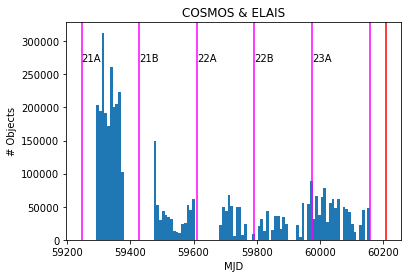

In [8]:
plt.hist(raw_obj_mjd, bins=100)
for x in [0, 1, 2, 3, 4, 5]:
    plt.axvline(sem_dates[x].mjd, color='magenta')
for x in [0, 1, 2, 3, 4]:    
    plt.text(sem_dates[x].mjd, 270000, semesters[x])
plt.axvline(Time.now().mjd, color='red')
plt.xlabel('MJD')
plt.ylabel('# Objects')
plt.title('COSMOS & ELAIS')
plt.show()

Plot relations between the object magnitude, R/B score, and magnitude errors (for all filters, all together).

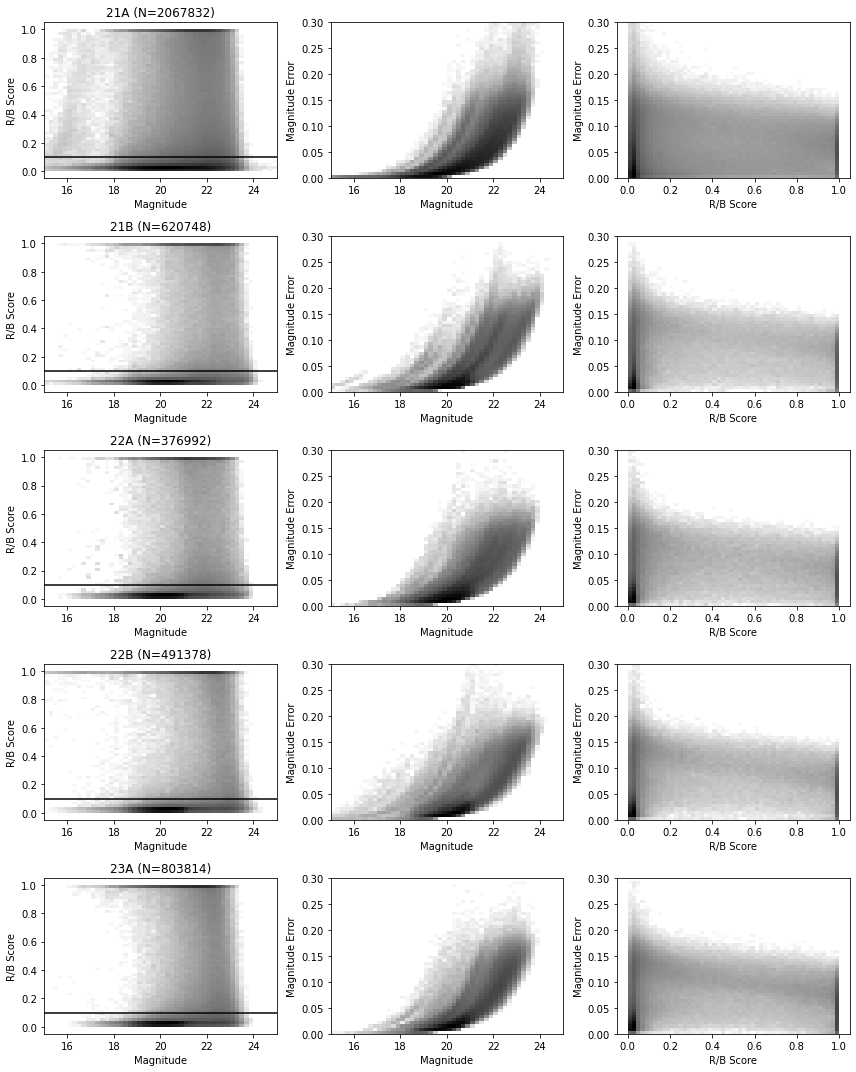

In [9]:
fig, ax = plt.subplots(5, 3, figsize=(12, 15))
for x in [0, 1, 2, 3, 4]:
    tx = np.where((raw_obj_mjd > sem_dates[x].mjd) & 
                  (raw_obj_mjd <= sem_dates[x+1].mjd) & 
                  np.isfinite(raw_obj_mag) & 
                  np.isfinite(raw_obj_rb) & 
                  np.isfinite(raw_obj_mage))[0]
    
    # heatmap version
    ax[x, 0].hist2d(raw_obj_mag[tx], raw_obj_rb[tx], bins=50, range=[[15, 25],[0.0,1.0]], 
                    cmap='Greys', norm=LogNorm(clip=True))
    ax[x, 1].hist2d(raw_obj_mag[tx], raw_obj_mage[tx], bins=50, range=[[15, 25],[0.0,0.3]], 
                    cmap='Greys', norm=LogNorm(clip=True))
    ax[x, 2].hist2d(raw_obj_rb[tx], raw_obj_mage[tx], bins=50, range=[[0.0,1.0],[0.0,0.3]], 
                    cmap='Greys', norm=LogNorm(clip=True))
    
    # scatterplot version
    # ax[x, 0].plot(raw_obj_mag[tx], raw_obj_rb[tx], 'o', ms=2, alpha=0.05, mew=0, color='grey')
    # ax[x, 1].plot(raw_obj_mag[tx], raw_obj_mage[tx], 'o', ms=2, alpha=0.05, mew=0, color='grey')
    # ax[x, 2].plot(raw_obj_rb[tx], raw_obj_mage[tx], 'o', ms=2, alpha=0.05, mew=0, color='grey')

    # plot R/B=0.1 line and set title for left column
    ax[x, 0].axhline(0.1, color='black')
    ax[x, 0].set_title(semesters[x]+' (N='+str(len(tx))+')')    
    
    # set axes labels and limits
    ax[x, 0].set_xlabel('Magnitude')
    ax[x, 0].set_xlim([15, 25])
    ax[x, 0].set_ylabel('R/B Score')
    ax[x, 0].set_ylim([-0.05,1.05])
    ax[x, 1].set_xlabel('Magnitude')
    ax[x, 1].set_xlim([15, 25])
    ax[x, 1].set_ylabel('Magnitude Error')
    ax[x, 1].set_ylim([0.0,0.3])
    ax[x, 2].set_xlabel('R/B Score')
    ax[x, 2].set_xlim([-0.05,1.05])
    ax[x, 2].set_ylabel('Magnitude Error')
    ax[x, 2].set_ylim([0.0,0.3])
    
    del tx

plt.tight_layout()
fig.show()

## 2. Identify "good" candidates, 2021-2022

### 2.1. Delete "bad" objects

Delete all objects with an R/B < 0.1.

In [10]:
dx = np.where(raw_obj_rb < 0.1)[0]

tmp_obj_ra     = np.delete(raw_obj_ra, dx)
tmp_obj_dec    = np.delete(raw_obj_dec, dx)
tmp_obj_mag    = np.delete(raw_obj_mag, dx)
tmp_obj_mage   = np.delete(raw_obj_mage, dx)
tmp_obj_rb     = np.delete(raw_obj_rb, dx)
tmp_obj_filt   = np.delete(raw_obj_filt, dx)
tmp_obj_mjd    = np.delete(raw_obj_mjd, dx)
tmp_obj_candid = np.delete(raw_obj_candid, dx)
tmp_obj_propid = np.delete(raw_obj_propid, dx)

print('Number of objects deleted: ', len(dx))
print('As a fraction of total raw objects: ', np.round(len(dx)/len(raw_obj_ra), 2))
print('Number of objects remaining: ', len(tmp_obj_ra))

del dx
del raw_obj_ra, raw_obj_dec, raw_obj_mag, raw_obj_mage
del raw_obj_rb, raw_obj_filt, raw_obj_mjd, raw_obj_candid, raw_obj_propid

Number of objects deleted:  3240118
As a fraction of total raw objects:  0.74
Number of objects remaining:  1138040


### 2.2. Identify "good" candidates

#### 2.2.1. Delete candidates with < 10 objects

Get the unique candidate ids, and delete all candidates (and their objects)
for which the number of objects per candidate is < 10.

Documentation for `numpy.unique`: https://numpy.org/doc/stable/reference/generated/numpy.unique

```
values  : sorted unique candidate ids
indices : the indices of `tmp_obj_candid` that give `values`
inverse : the indices of `values` that reconstruct `tmp_obj_candid`
counts  : the number of times each unique candidate id appears in `tmp_obj_candid`
```

In other words, `counts` is the number of objects per candidate.

In [11]:
values, indices, inverse, counts = np.unique(tmp_obj_candid, return_index=True, 
                                             return_inverse=True,  return_counts=True)

In [12]:
print('On average, %4.2f objects per candidate' % (len(tmp_obj_candid)/len(values)))

On average, 5.72 objects per candidate


Plot the distribution of the number of objects per candidate.
Draw a horizontal line at 10, the cutoff we will apply for "good" candidates.

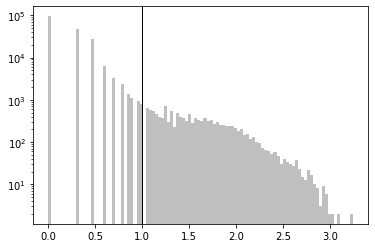

In [13]:
plt.hist(np.log10(counts), bins=100, log=True, alpha=0.5, color='grey')
plt.axvline(np.log10(10), ls='solid', lw=1, color='black')
plt.show()

Delete all objects of candidates with less than 10 objects.

In [14]:
dx = np.where(counts[inverse] < 10)[0]

obj_ra     = np.delete(tmp_obj_ra, dx)
obj_dec    = np.delete(tmp_obj_dec, dx)
obj_mag    = np.delete(tmp_obj_mag, dx)
obj_mage   = np.delete(tmp_obj_mage, dx)
obj_rb     = np.delete(tmp_obj_rb, dx)
obj_filt   = np.delete(tmp_obj_filt, dx)
obj_mjd    = np.delete(tmp_obj_mjd, dx)
obj_candid = np.delete(tmp_obj_candid, dx)
obj_propid = np.delete(tmp_obj_propid, dx)

print('Number of objects deleted: ', len(dx))
print('As a fraction of current number of objects: ', np.round(len(dx)/len(tmp_obj_ra), 2))
print('Number of objects remaining: ', len(obj_ra))

del dx
del tmp_obj_ra, tmp_obj_dec, tmp_obj_mag, tmp_obj_mage
del tmp_obj_rb, tmp_obj_filt, tmp_obj_mjd, tmp_obj_candid, tmp_obj_propid
del values, indices, inverse, counts

Number of objects deleted:  355784
As a fraction of current number of objects:  0.31
Number of objects remaining:  782256


Get the number of unique candidates now.

In [15]:
values, indices, inverse, counts = np.unique(obj_candid, return_index=True, 
                                             return_inverse=True, return_counts=True)

In [16]:
print('On average, %4.2f objects per candidate' % (len(obj_candid)/len(values)))

On average, 57.00 objects per candidate


#### 2.2.2. Delete candidates with mean R/B < 0.4

Create temporary arrays to hold candidate info:

```
cand_ids    : list of unqiue candidates
cand_nobjs  : number of objects per candidate
cand_meanrb : mean R/B score for candidates' objects
```

In [17]:
tmp_cand_ids = values
tmp_cand_nobjs = counts
tmp_cand_meanrb = np.zeros(len(tmp_cand_ids), dtype='float')

Calculate the mean R/B score for each candidate, `cand_mrb`.

This takes about 1 minute.

In [18]:
%%time
t0 = time.time()
for c, cid in enumerate(tmp_cand_ids):
    if (c == 100) | (c == 1000) | (c == 10000):
        t1 = time.time()
        print('c = %5i, elapsed = %5.1f seconds' % (c, t1 - t0))
        del t1
    cx = np.where(obj_candid == cid)[0]
    tmp_cand_nobjs[c] = len(cx)
    tmp_cand_meanrb[c] = np.nanmean(obj_rb[cx])
    del cx

c =   100, elapsed =   0.6 seconds
c =  1000, elapsed =   6.3 seconds
c = 10000, elapsed =  61.4 seconds
CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 1min 22s


Delete candidates with a mean R/B score < 0.4 from the candidate arrays.

In [19]:
dx = np.where(tmp_cand_meanrb < 0.4)[0]

cand_ids = np.delete(tmp_cand_ids, dx)
cand_nobjs = np.delete(tmp_cand_nobjs, dx)
cand_meanrb = np.delete(tmp_cand_meanrb, dx)

print('Number of candidates deleted: ', len(dx))
print('As a fraction of current number of candidates: ', np.round(len(dx)/len(tmp_cand_ids), 2))
print('Number of candidates remaining: ', len(cand_ids))

del dx
del tmp_cand_ids, tmp_cand_nobjs, tmp_cand_meanrb

Number of candidates deleted:  4725
As a fraction of current number of candidates:  0.34
Number of candidates remaining:  8998


## 3. Create candidate nightly-epoch lightcurves

"Nightly-epoch" means all observations per filter per candidate in a given 
night are combined into a single photometry point.

Although we have limited only to candidates with mean R/B scores over
*all* objects are > 0.4, an individual nightly-epoch might have a mean R/B < 0.4.

### 3.1. Combine photometry into nightly-epochs

Use lists, first, and prefix with `tmp`.
Then store results in numpy arrays.

```
ne_candid : candidate id
ne_field  : field (COSMOS or ELAIS)
ne_cal    : calendar date
ne_mjd    : modified julian date
ne_fil    : filter (g, r, i)
ne_nobj   : number of objects combined
ne_mag    : combined magnitude
ne_mage   : combined magnitude error
ne_mrb    : mean R/B score of combined objects
```

Set up the array of unique MJDs and unique calendar dates.

Use every MJD since January 1 2021 as the set of unique mjds (umjd). JD = 2459215.5, MJD = 59215.0.

Use this range for combining into a nightly epoch: $umjd - 0.1 < mjd < umjd + 0.5$.

For the associated calendar date ("local night of"), use $umjd - 0.1$ as calendar date.

In [31]:
umjds = 59216.0 + np.arange(1000, dtype='float')
# print(umjds)

In [32]:
temp1 = 59216.0 + np.arange(1000, dtype='float') - 0.1
temp2 = Time(temp1, format='mjd')
temp3 = []
for t in range(len(temp2)):
    temp4 = temp2[t].isot
    temp3.append(temp4[0:10])
    del temp4
ucals = np.asarray(temp3, dtype='str')
del temp1, temp2, temp3
# print(ucals)

This takes a few minutes.

In [34]:
t1 = time.time()

tmp_ne_candid = []
tmp_ne_field = []
tmp_ne_cal = []
tmp_ne_mjd = []
tmp_ne_fil = []
tmp_ne_nobj = []
tmp_ne_mag = []
tmp_ne_mage = []
tmp_ne_mrb = []

for c in range(len(cand_ids)):
    tally_ne = 0
    
    if (c == 10) | (c == 100) | (c == 1000):
        t2 = time.time()
        print('c=%6i, %5.1f seconds remain' % (c, ((t2-t1)/float(c))*(float(len(cand_ids)-c))))
       
    cx = np.where(obj_candid == cand_ids[c])[0]
    
    if (np.mean(obj_ra[cx]) > 5.0) & (np.mean(obj_ra[cx]) < 12.0):
        field = 'ELAIS'
    else:
        field = 'COSMOS'
    
    ### THE OLD WAY WAS TO CREATE UMJDS AND UCALS FOR THE CANDIDATE
    # mjds = obj_mjd[cx]
    # temp = Time(mjds, format='mjd')
    # temp2 = temp.isot
    # temp3 = []
    # for i in temp2:
    #     temp3.append(i[0:10])    
    # ucals, indices = np.unique(temp3, return_index=True)
    # umjds = mjds[indices]
    # del temp, temp2, temp3, indices
    
    ### THE NEW WAY USES THE SAME SET OF UMJDS AND UCALS FOR ALL CANDIDATES

    for d, mjd in enumerate(umjds):
        
        for f, fil in enumerate(['g','r','i']):
            # fx = np.where((np.abs(obj_mjd[cx] - mjd) < 0.4) & 
            fx = np.where((mjd - 0.1 < obj_mjd[cx]) & (obj_mjd[cx] < mjd + 0.5) & 
                          (obj_filt[cx] == fil) & 
                          (np.isfinite(obj_mag[cx])) & 
                          (obj_mag[cx] > 0.0))[0]
            
            if len(fx) >= 2:
                tmp_ne_field.append(field)
                tmp_ne_candid.append(cand_ids[c])
                tmp_ne_cal.append(ucals[d])
                tmp_ne_mjd.append(np.mean(obj_mjd[cx[fx]]))
                tmp_ne_fil.append(fil)
                tmp_ne_nobj.append(len(obj_mjd[cx[fx]]))
                tmp_ne_mag.append(np.mean(obj_mag[cx[fx]]))
                tmp_ne_mage.append(np.sqrt(np.mean(obj_mage[cx[fx]])**2 + \
                                            np.std(obj_mag[cx[fx]])**2))
                tmp_ne_mrb.append(np.mean(obj_rb[cx[fx]]))
                tally_ne += 1
            
            elif len(fx) == 1:
                tmp_ne_field.append(field)
                tmp_ne_candid.append(cand_ids[c])
                tmp_ne_cal.append(ucals[d])
                tmp_ne_mjd.append(obj_mjd[cx[fx[0]]])
                tmp_ne_fil.append(fil)
                tmp_ne_nobj.append(1)
                tmp_ne_mag.append(obj_mag[cx[fx[0]]])
                tmp_ne_mage.append(obj_mage[cx[fx[0]]])
                tmp_ne_mrb.append(obj_rb[cx[fx[0]]])
                tally_ne += 1
                
            del fx
    
    if tally_ne == 0:
        print('warning: ', cand_id[c], ' no nightly epochs with detections')
    del cx

ne_field  = np.asarray(tmp_ne_field, dtype='str')
ne_candid = np.asarray(tmp_ne_candid, dtype='str')
ne_nobj   = np.asarray(tmp_ne_nobj, dtype='int')
ne_mjd    = np.asarray(tmp_ne_mjd, dtype='float')
ne_cal    = np.asarray(tmp_ne_cal, dtype='str')
ne_fil    = np.asarray(tmp_ne_fil, dtype='str')
ne_mag    = np.asarray(tmp_ne_mag, dtype='float')
ne_mage   = np.asarray(tmp_ne_mage, dtype='float')
ne_mrb    = np.asarray(tmp_ne_mrb, dtype='float')

del tmp_ne_field, tmp_ne_candid, tmp_ne_nobj, tmp_ne_mjd, tmp_ne_cal
del tmp_ne_fil, tmp_ne_mag, tmp_ne_mage, tmp_ne_mrb, tally_ne

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))

c=    10, 361.5 seconds remain
c=   100, 354.0 seconds remain
c=  1000, 314.9 seconds remain
elapsed: 371.8


### 3.1. Create the "lonely epoch" flag

As described above, an individual nightly-epoch might have a mean R/B < 0.4.

These low-R/B nightly-epochs do contribute to the lightcurve summary parameters,
but only if they are not a "*lonely epoch*".

A "*lonely epoch*" is a nightly-epoch, for a given filter, for which the 
mean R/B score of its objects is < 0.4 *and* there is no other epoch
within 14 days for which the mean R/B score was > 0.4 (in any filter).

"*Lonely epochs*" are much more likely to be spurious detections that
are coincident with a candidate, and can throw off the values of the
lightcurve summary parameters (e.g., extend the time span).

```
ne_loneflag : lonely epoch flag (True if it is a lonely epoch)
```

This takes a couple of minutes.

In [35]:
t1 = time.time()

ne_loneflag = np.zeros(len(ne_mrb), dtype='int')

for c, cand in enumerate(cand_ids):

    if (c == 10) | (c == 100) | (c == 1000):
        t2 = time.time()
        print('c=%6i, %5.1f seconds remain' % (c, ((t2-t1)/float(c))*(float(len(cand_ids)-c))))
    
    for f, filt in enumerate(['g','r','i']):
        tx1 = np.where((ne_candid == cand) & (ne_fil == filt))[0]
        tx2 = np.where((ne_candid == cand) & (ne_fil == filt) & (ne_mrb > 0.4))[0]
        
        if len(tx1) == 1:
            if ne_mrb[tx1[0]] < 0.4:
                ne_loneflag[tx1[0]] = 1
        elif (len(tx1) > 1) & (len(tx2) == 0):
            for x1 in tx1:
                ne_loneflag[x1] = 1            
        elif (len(tx1) > 1) & (len(tx2) > 0):
            for i, x1 in enumerate(tx1):
                if ne_mrb[x1] < 0.4:
                    nearest_good = np.min(np.abs(ne_mjd[x1] - ne_mjd[tx2]))
                    if nearest_good > 14:
                        ne_loneflag[x1] = 1
                    del nearest_good
        
        del tx1, tx2

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

c=    10, 213.3 seconds remain
c=   100, 210.1 seconds remain
c=  1000, 188.7 seconds remain
elapsed: 213.7


In [36]:
tx = np.where(ne_loneflag == 1)[0]
print('Number and fraction of lonely epochs: ', len(tx), np.round(len(tx)/len(ne_loneflag), 2))
del tx

Number and fraction of lonely epochs:  23933 0.09


### 3.2. Write the nightly-epoch lightcurves to file

In [37]:
fnm = 'all_nightly_epochs_files/candidate_lightcurves.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, candidate_nightly_epochs.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field  \n')
fout.write('#  1 id -- candidate identifier \n')
fout.write('#  2 calendar date \n')
fout.write('#  3 MJD \n')
fout.write('#  4 filter \n')
fout.write('#  5 number of objects combined \n')
fout.write('#  6 magnitude (mean of objects combined) \n')
fout.write('#  7 magnitude error \n')
fout.write('#  8 real/bogus (mean of objects combined) \n')
fout.write('#  9 lonely epoch flag \n')
fout.write('# \n')

for i in range(len(ne_candid)):
    fout.write('%-9s %-14s %-8s %12.6f '\
               '%1s %3i %6.3f %6.3f %6.4f %1i \n' % \
               (ne_field[i], ne_candid[i], ne_cal[i], ne_mjd[i], \
                ne_fil[i], ne_nobj[i], ne_mag[i], ne_mage[i], ne_mrb[i], ne_loneflag[i]) )

fout.close()
print('Wrote to: ', fnm)
del fnm

Wrote to:  all_nightly_epochs_files/candidate_lightcurves.dat


## 4. Calculate the lightcurve summary parameters

Recall that "lonely epochs" are not included in the calculation of the summary parameters.

Lightcurve summary parameters include:

```
tspan  : time span, the mjd of the last minus the first nightly-epoch
minmag : minimum magnitude, apparent magnitude of the brightest nightly-epoch
lcamp  : lightcurve amplitude, the difference between the brightest and faintest nightly-epoch
nde    : number of non-lonely epochs
```

This takes a couple of minutes.

In [38]:
t1 = time.time()

### timespan (last date - first date of detection)
nelc_tspan = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_g = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_r = np.zeros( len(cand_ids), dtype='float' )
nelc_tspan_i = np.zeros( len(cand_ids), dtype='float' )

### minimum magnitude (brightest detection)
nelc_minmag = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_g = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_r = np.zeros( len(cand_ids), dtype='float' )
nelc_minmag_i = np.zeros( len(cand_ids), dtype='float' )

### amplitude (maximum - minimum detection)
nelc_lcamp = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_g = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_r = np.zeros( len(cand_ids), dtype='float' )
nelc_lcamp_i = np.zeros( len(cand_ids), dtype='float' )

### number of epochs with detections
nelc_nde = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_g = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_r = np.zeros( len(cand_ids), dtype='int' )
nelc_nde_i = np.zeros( len(cand_ids), dtype='int' )

tempfield = []

### for every candidate
for c, candid in enumerate(cand_ids):
    if (c == 10) | (c == 100) | (c == 1000):
        t2 = time.time()
        print('c=%6i, %5.1f seconds remain' % (c, ((t2-t1)/float(c))*(float(len(cand_ids)-c))))
        
    ### at first, skip the loneflag constraint to fill tempfield and check mag issues
    cx = np.where( (ne_candid == candid) & (ne_nobj >= 1) )[0]
    tempfield.append(ne_field[cx[0]])
    ### where the nobj >= 1, the mag should never be nan
    tx = np.where( np.isnan( ne_mag[cx] ) )[0]
    if len(tx) != 0:
        print('warning, ', candid, ' has a nobj >=1, mag=nan epoch')
    del tx

    ### but now, can apply the loneflag constraint if wanted
    # cx = np.where( (ne_candid == candid) & (ne_nobj >= 1) )[0]
    cx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_loneflag == 0) )[0]
    if len(cx) > 0:
        temp = np.unique( ne_cal[cx] )
        nelc_nde[c] = len(temp)
        del temp
        nelc_tspan[c]  = np.max( ne_mjd[cx] ) - np.min( ne_mjd[cx] )
        nelc_minmag[c] = np.min( ne_mag[cx] )
        nelc_lcamp[c]  = np.max( ne_mag[cx] ) - np.min( ne_mag[cx] )
    del cx

    # gx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'g') )[0]
    # rx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'r') )[0]
    # ix = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'i') )[0]
    gx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'g') & (ne_loneflag == 0) )[0]
    rx = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'r') & (ne_loneflag == 0) )[0]
    ix = np.where( (ne_candid == candid) & (ne_nobj >= 1) & (ne_fil == 'i') & (ne_loneflag == 0) )[0]
    if len(gx) > 0:
        nelc_nde_g[c]    = len(gx)
        nelc_tspan_g[c]  = np.max( ne_mjd[gx] ) - np.min( ne_mjd[gx] )
        nelc_minmag_g[c] = np.min( ne_mag[gx] )
        nelc_lcamp_g[c]  = np.max( ne_mag[gx] ) - np.min( ne_mag[gx] )
    if len(rx) > 0:
        nelc_nde_r[c]    = len(rx)
        nelc_tspan_r[c]  = np.max( ne_mjd[rx] ) - np.min( ne_mjd[rx] )
        nelc_minmag_r[c] = np.min( ne_mag[rx] )
        nelc_lcamp_r[c]  = np.max( ne_mag[rx] ) - np.min( ne_mag[rx] )
    if len(ix) > 0:
        nelc_nde_i[c]    = len(ix)
        nelc_tspan_i[c]  = np.max( ne_mjd[ix] ) - np.min( ne_mjd[ix] )
        nelc_minmag_i[c] = np.min( ne_mag[ix] )
        nelc_lcamp_i[c]  = np.max( ne_mag[ix] ) - np.min( ne_mag[ix] )
    del gx,rx,ix

cand_field = np.asarray(tempfield, dtype='str')
del tempfield

t2 = time.time()
print('elapsed: %5.1f' % (t2 - t1))
del t1, t2

c=    10, 148.0 seconds remain
c=   100, 145.0 seconds remain
c=  1000, 131.1 seconds remain
elapsed: 151.3


### 4.1. Write the lightcurve summary parameters to file

In [39]:
fnm = 'all_nightly_epochs_files/candidate_lightcurve_parameters.dat'
fout = open(fnm, 'w')

fout.write('# Melissa Graham, candidate_nightly_epochs.ipynb \n')
tnow = time.strftime("%a, %d %b %Y %H:%M:%S +0000", time.gmtime())
fout.write('# UTC = '+tnow+' \n')
del tnow
fout.write('# \n')
fout.write('# Columns \n')
fout.write('#  0 field  \n')
fout.write('#  1 id -- candidate identifier \n')
fout.write('#  2 timespan (days between first and last detection) \n')
fout.write('#  3 timespan in g \n')
fout.write('#  4 timespan in r \n')
fout.write('#  5 timespan in i \n')
fout.write('#  6 minimum magnitude (not necessarily the peak) \n')
fout.write('#  7 minimum magnitude g \n')
fout.write('#  8 minimum magnitude r \n')
fout.write('#  9 minimum magnitude i \n')
fout.write('# 10 amplitude (magnitudes between brightest and faintest detection) \n')
fout.write('# 11 amplitude g \n')
fout.write('# 12 amplitude r \n')
fout.write('# 13 amplitude i \n')
fout.write('# 14 number of non-lonely epochs (number of unique nights detected) \n')
fout.write('# 15 number of non-lonely epochs in g \n')
fout.write('# 16 number of non-lonely epochs in r \n')
fout.write('# 17 number of non-lonely epochs in i \n')
fout.write('# \n')

for i in range(len(cand_ids)):
    fout.write('%-8s %-14s %7.2f %7.2f %7.2f %7.2f %6.3f %6.3f %6.3f %6.3f %6.3f %6.3f '\
               '%6.3f %6.3f %3i %3i %3i %3i \n' % \
               (cand_field[i], cand_ids[i], \
                nelc_tspan[i], nelc_tspan_g[i], nelc_tspan_r[i], nelc_tspan_i[i], \
                nelc_minmag[i], nelc_minmag_g[i], nelc_minmag_r[i], nelc_minmag_i[i], \
                nelc_lcamp[i], nelc_lcamp_g[i], nelc_lcamp_r[i], nelc_lcamp_i[i], \
                nelc_nde[i], nelc_nde_g[i], nelc_nde_r[i], nelc_nde_i[i] ) )

fout.close()
print('Wrote to: ',fnm)
del fnm

Wrote to:  all_nightly_epochs_files/candidate_lightcurve_parameters.dat
